In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv
/kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database/olist.sqlite


# GET THE DATA

In [2]:
import sqlite3

db_path = '/kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database/olist.sqlite'
db_connection = sqlite3.connect(db_path)

# CUSTOM VIEW TABLE FN

In [3]:
def view_table(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

# ORDERS

In [4]:
# Table orders, first 3 columns
view_table('orders', 5).iloc[:, :3]

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered


In [5]:
# Table orders, timestamp columns
view_table('orders', 5).iloc[:, 3:]

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
orders_per_day = """
SELECT
    DATE(order_purchase_timestamp) AS day,
    COUNT(*) AS order_count
FROM orders
GROUP BY day
"""
df = pd.read_sql_query(orders_per_day, db_connection)
df.head(5)


,day,order_count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


In [7]:
order_day_hour = """
SELECT
    -- Day of the week abreviated
    CASE STRFTIME('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Mon'
        WHEN '2' THEN 'Tue'
        WHEN '3' THEN 'Wed'
        WHEN '4' THEN 'Thu'
        WHEN '5' THEN 'Fri'
        WHEN '6' THEN 'Sat'
        WHEN '0' THEN 'Sun'
        END AS day_of_week_name,
    -- Day of the week as integer (Sunday=7)
    CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS day_of_week_int,
    -- Hour of the day (0-24)
    CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hour
FROM orders
"""

pd.read_sql_query(order_day_hour, db_connection)

,day_of_week_name,day_of_week_int,hour
0,Mon,1,10
1,Tue,2,20
2,Wed,3,8
3,Sat,6,19
4,Tue,2,21
...,...,...,...
99436,Thu,4,9
99437,Tue,2,12
99438,Sun,0,14
99439,Mon,1,21


In [8]:
count_orders_per_hour = ',\n    '.join([
    f'COUNT(CASE WHEN hour = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

orders_per_day_of_the_week_and_hour = f"""
WITH OrderDayHour AS (
    {order_day_hour}
)
SELECT
    day_of_week_name,
    {count_orders_per_hour}
FROM OrderDayHour
GROUP BY day_of_week_int
ORDER BY day_of_week_int
"""

In [9]:
df = pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)
df = df.set_index('day_of_week_name')
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week_name,,,,,,,,,,,,,,,,,,,,,
Sun,267,141,69,44,27,27,34,105,205,349,...,684,716,712,797,895,899,967,889,873,607
Mon,328,134,66,36,21,22,69,160,479,783,...,1096,1079,1094,992,928,945,1027,1118,991,717
Tue,306,158,80,28,29,24,71,223,522,864,...,1124,1047,1081,967,877,924,988,1027,965,692
Wed,397,179,81,33,33,27,93,211,517,829,...,1050,983,1040,967,852,848,904,963,878,615
Thu,355,167,75,39,31,28,85,220,502,758,...,977,928,1077,909,784,826,839,840,857,551
Fri,426,216,72,49,40,36,97,206,493,768,...,961,979,974,817,723,784,738,726,702,512
Sat,315,175,67,43,25,24,53,106,249,434,...,677,722,697,701,710,756,730,654,550,429


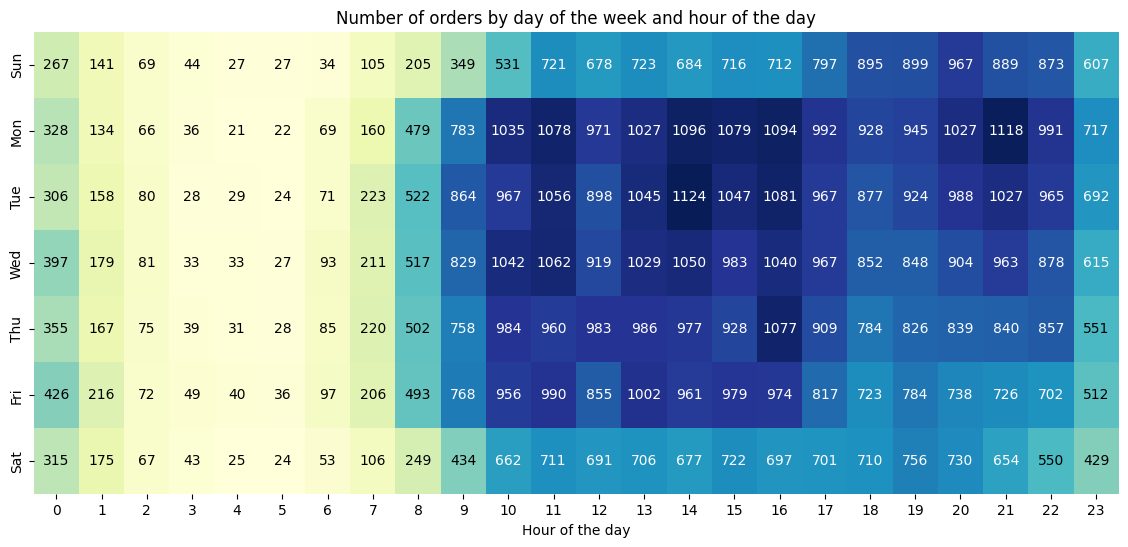

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df, cmap='YlGnBu', cbar=False)
mean_orders = df.mean().mean()
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = 'white' if df.iloc[i, j] > mean_orders else 'black'
        ax.text(j+0.5, i+0.5, int(df.iloc[i, j]),
            color=text_color, fontsize=10, ha="center", va="center")
plt.title("Number of orders by day of the week and hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("")
plt.show()

We can observe that most orders were placed during the weekdays from 10 AM to 4 PM with a small dip in sales around 12 PM due to lunchtime. Customers also order through Olist in the evenings around 9 PM from Sunday to Thursday. Saturday is the day with the fewest orders, although it's still quite busy. The least busy time of the day is from 3 to 5 AM, although there are still a few orders during that time.

# CUSTOMERS

In [11]:
view_table('customers', 5)



,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
orders_per_city = """
SELECT 
    customer_city AS customer_city,
    UPPER(customer_city) AS city,
    COUNT(orders.order_id) as city_order_count
FROM 
    customers
    JOIN orders USING (customer_id)
GROUP BY UPPER(customer_city)
ORDER BY city_order_count DESC
LIMIT 10
"""

pd.read_sql_query(orders_per_city, db_connection)


,customer_city,city,city_order_count
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


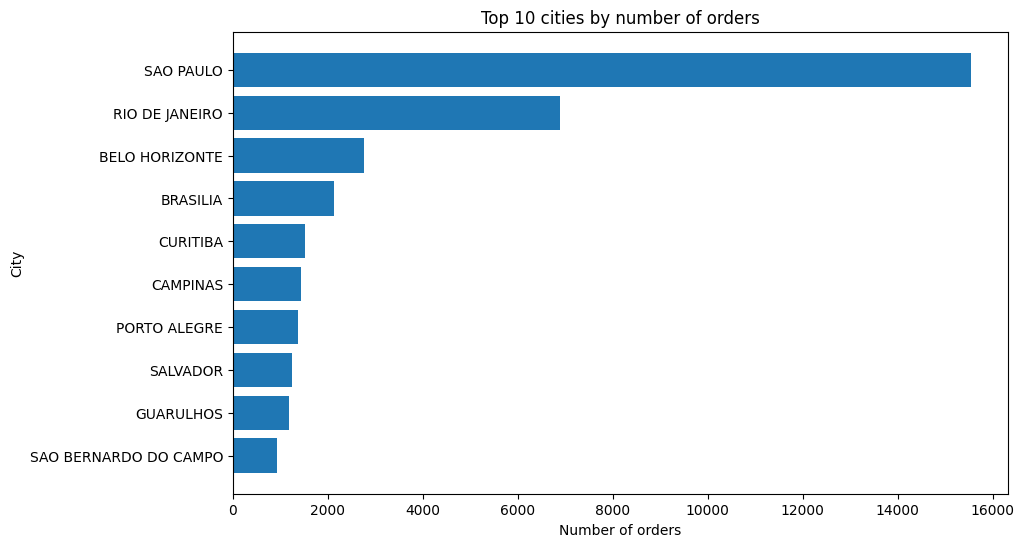

In [13]:

orders_per_city_reversed = f"""
SELECT *
FROM ({orders_per_city})
ORDER BY city_order_count
"""
top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)

plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'], top_cities['city_order_count'])
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

As we can see, a lot more orders are placed in São Paulo and Rio de Janerio than in other cities, as you'd expect since these are also the largest cities in Brazil

# ORDER ITEMS

In [14]:
# Table order_items, first 4 columns
view_table('order_items', 5).iloc[:, :4]

,order_id,order_item_id,product_id,seller_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87


In [15]:
# Table order_items, last 2 columns
view_table('order_items', 5).iloc[:, 5:]

,price,freight_value
0,58.90,13.29
1,239.90,19.93
2,199.00,17.87
3,12.99,12.79
4,199.90,18.14


What's the average order price, considering both the cost of products and shipping? To start, let's find the orders with the lowest and the highest costs:

In [16]:
order_price_stats = """
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(order_price_stats, db_connection)

,min_order_price,avg_order_price,max_order_price
0,9.59,160.58,13664.08


* The average order price is 160.58 BRL, which is around the cost of a pair of sports shoes in 2017 in Brazil.
*  As we can see, the most expensive order is 13664.08, almost 100 times the average, meaning we probably have a right-tailed distribution, where most of the orders have low cost but there are orders with a very high cost

In [17]:
order_product_and_shipping_costs = """
SELECT
    orders.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)
df

,order_id,product_cost,shipping_cost
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


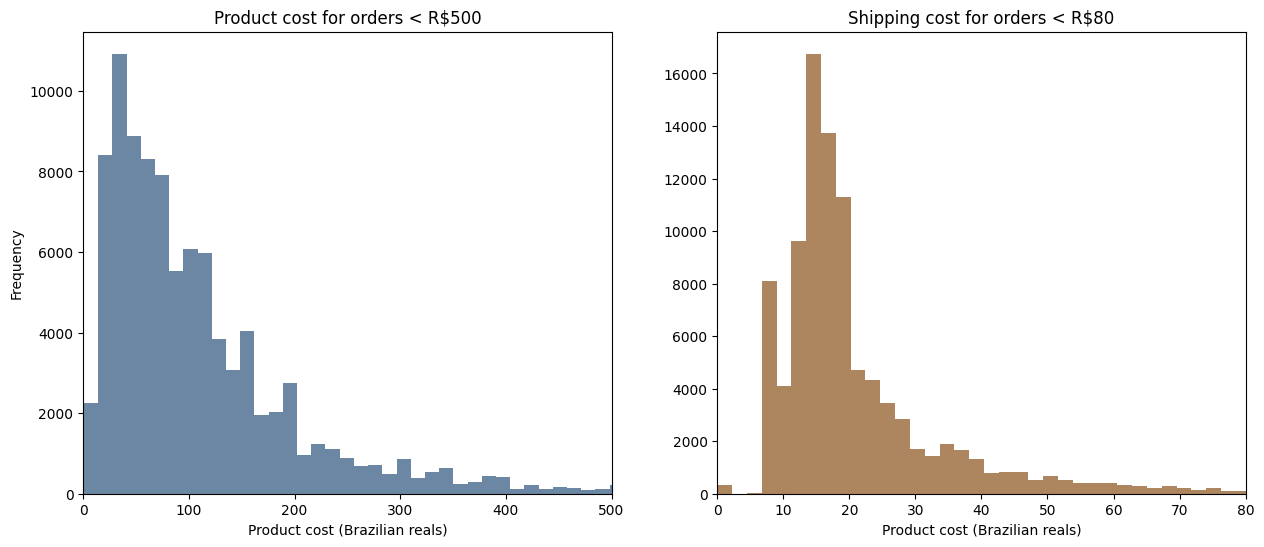

In [18]:
plt.figure(figsize=(15, 6))
# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#6c87a3')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])
# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#ad865f')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Product cost (Brazilian reals)')
plt.xlim([0, 80])
plt.show()

* The value of products in an order can vary wildly and take from very low to very high values, although most orders contain products with a total cost under 200 reals.

* Shipping cost is usually between 7-20 reals, and rarely below that, but it can also take a wide range of much higher values.

# PRODUCTS

In [19]:
view_table('products', 5).iloc[:, [0, 1, 5]]


,product_id,product_category_name,product_weight_g
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0


In [20]:
ranked_categories = """
SELECT
    product_category_name_english AS category,
    SUM(price) AS sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS rank
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
"""

pd.read_sql_query(ranked_categories, db_connection)

,category,sales,rank
0,health_beauty,1233131.72,1
1,watches_gifts,1166176.98,2
2,bed_bath_table,1023434.76,3
3,sports_leisure,954852.55,4
4,computers_accessories,888724.61,5
...,...,...,...
66,flowers,1110.04,67
67,home_comfort_2,760.27,68
68,cds_dvds_musicals,730.00,69
69,fashion_childrens_clothes,519.95,70


CTE

In [21]:
category_sales_summary = f"""
WITH RankedCategories AS (
    {ranked_categories}
)
-- Top 18 categories by sales
SELECT
    category,
    sales
FROM RankedCategories
WHERE rank <= 18
-- Other categories, aggregated
UNION ALL
SELECT
    'Other categories' AS category,
    SUM(sales) AS sales
FROM RankedCategories
WHERE rank > 18
"""

df = pd.read_sql_query(category_sales_summary, db_connection)
df

,category,sales
0,health_beauty,1233131.72
1,watches_gifts,1166176.98
2,bed_bath_table,1023434.76
3,sports_leisure,954852.55
4,computers_accessories,888724.61
5,furniture_decor,711927.69
6,housewares,615628.69
7,cool_stuff,610204.10
8,auto,578966.65
9,toys,471286.48


In [22]:
top_18_categories = tuple(category for category in df['category'] if category != 'Other categories')

In [23]:
ordered_categories = f"""
SELECT
    product_weight_g AS weight,
    product_category_name_english AS category,
    ROW_NUMBER() OVER(PARTITION BY product_category_name_english ORDER BY product_weight_g)
        AS category_row_n,
    COUNT(*) OVER(PARTITION BY product_category_name_english) AS category_count
FROM
    products
    JOIN order_items USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    product_category_name_english IN {top_18_categories}
"""

df = pd.read_sql_query(ordered_categories, db_connection)
df

,weight,category,category_row_n,category_count
0,50.0,auto,1,4235
1,50.0,auto,2,4235
2,50.0,auto,3,4235
3,50.0,auto,4,4235
4,50.0,auto,5,4235
...,...,...,...,...
92419,15267.0,watches_gifts,5987,5991
92420,15267.0,watches_gifts,5988,5991
92421,15267.0,watches_gifts,5989,5991
92422,17175.0,watches_gifts,5990,5991


In [24]:
categories_by_median = f"""
WITH OrderedCategories AS (
    {ordered_categories}
)
SELECT category
FROM OrderedCategories
WHERE
    -- Odd number of products: Select the middle row
    (category_count % 2 = 1 AND category_row_n = (category_count + 1) / 2) OR
    -- Even number of products: Select the two middle rows to be averaged
    (category_count % 2 = 0 AND category_row_n IN ((category_count / 2), (category_count / 2 + 1)))
GROUP BY category
ORDER BY AVG(weight)
"""

categories_by_median_df = pd.read_sql_query(categories_by_median, db_connection)
categories_by_median_df

,category
0,telephony
1,computers_accessories
2,watches_gifts
3,health_beauty
4,perfumery
5,baby
6,sports_leisure
7,toys
8,pet_shop
9,auto


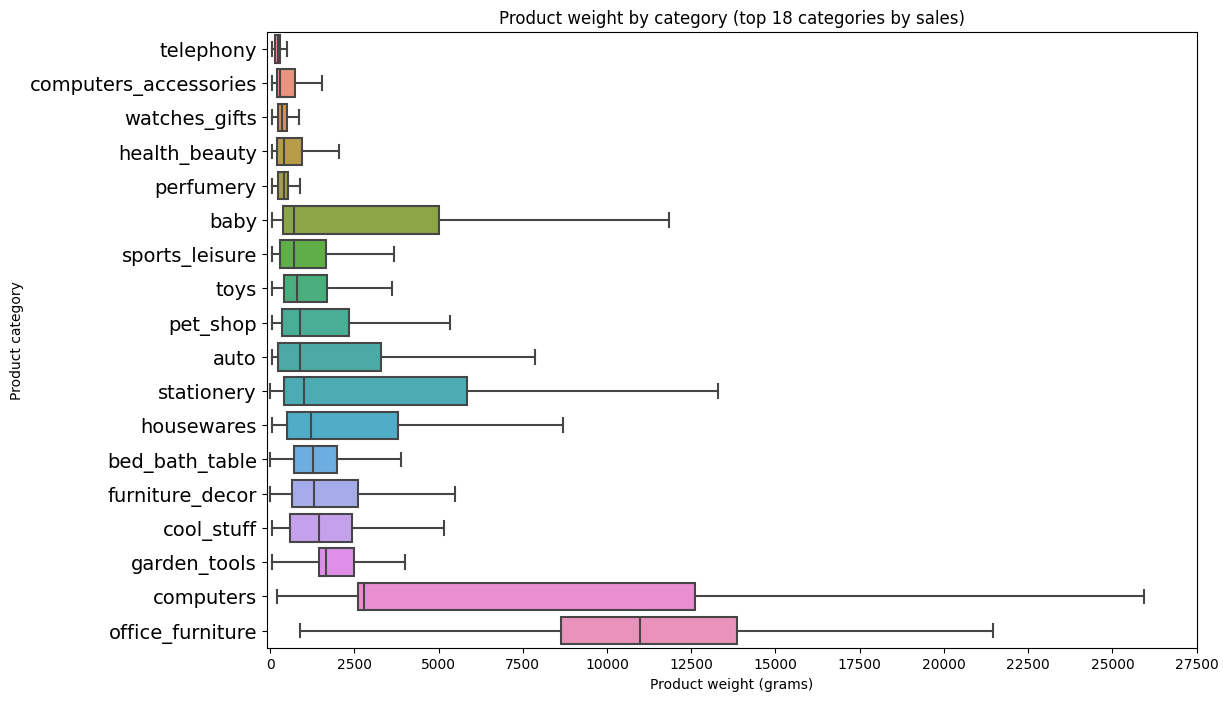

In [25]:
plt.figure(figsize=(12, 8))
order = categories_by_median_df['category'].tolist()
sns.boxplot(x='weight', y='category', data=df, order=order, showfliers=False)
plt.xlabel('Product weight (grams)')
plt.ylabel('Product category')
plt.title('Product weight by category (top 18 categories by sales)')
plt.xlim(-100, 26100)
plt.xticks(ticks=range(0, 30000, 2500))
plt.yticks(fontsize=14)
plt.show()

As we can see at the top of the plot, there are five categories whose items are mostly under 2 Kg: 'telephony', 'computers_accessories', 'watches_gifts', 'health_beauty'. At the bottom, we can see two categories, 'computers' and 'office_furniture', that include much heavier products.

In [26]:
selected_categories = ('health_beauty', 'auto', 'toys', 'electronics', 'fashion_shoes')

In [27]:
monthly_sales_selected_categories = f"""
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS year_month,
    SUM(CASE WHEN product_category_name_english = 'health_beauty' THEN price END) AS health_beauty,
    SUM(CASE WHEN product_category_name_english = 'auto' THEN price END) AS auto,
    SUM(CASE WHEN product_category_name_english = 'toys' THEN price END) AS toys,
    SUM(CASE WHEN product_category_name_english = 'electronics' THEN price END) AS electronics,
    SUM(CASE WHEN product_category_name_english = 'fashion_shoes' THEN price END) AS fashion_shoes
FROM orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_purchase_timestamp >= '2017-01-01'
    AND product_category_name_english IN {selected_categories}
GROUP BY year_month
"""

df = pd.read_sql_query(monthly_sales_selected_categories, db_connection)
df = df.set_index('year_month')
df

,health_beauty,auto,toys,electronics,fashion_shoes
year_month,,,,,
2017-01,12561.32,5218.53,4814.09,617.00,34.90
2017-02,22838.79,13162.40,9403.34,1218.85,107.05
2017-03,25995.25,14482.07,12429.47,3986.00,1515.00
2017-04,22935.75,15548.17,13039.43,4822.24,1526.50
2017-05,46786.02,18640.03,22626.95,6709.11,1669.54
2017-06,32029.39,31370.69,15476.35,2100.04,1351.20
2017-07,34896.86,14119.74,24511.72,7346.84,1423.01
2017-08,49873.90,20421.11,18126.87,2854.15,1491.69
2017-09,51537.65,14544.67,31399.22,4338.96,1179.60


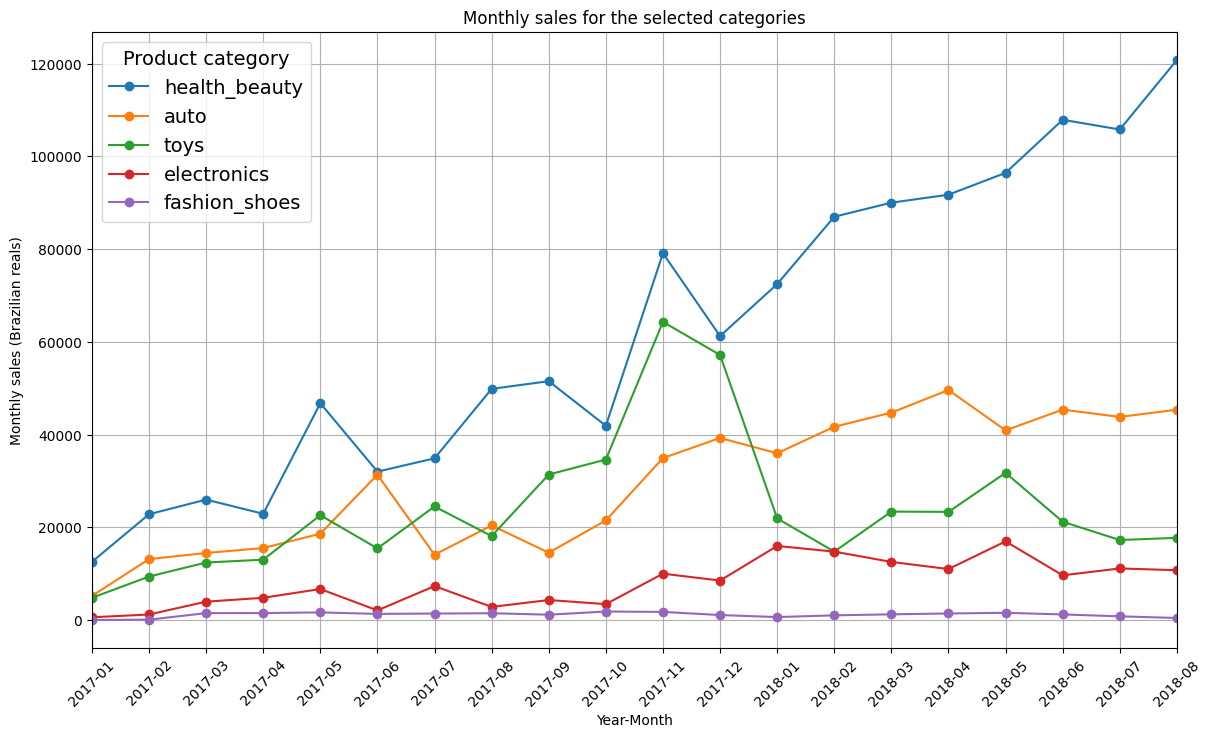

In [28]:
df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(ax=ax, marker='o', linestyle='-')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%Y-%m'), rotation=90)
plt.title('Monthly sales for the selected categories')
plt.xlabel('Year-Month')
plt.ylabel('Monthly sales (Brazilian reals)')
plt.xticks(rotation=45)
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

In [29]:
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    -- Days since 2017-01-01
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

pd.read_sql_query(daily_sales_per_category, db_connection)

,date,day,category,sales
0,2017-01-05,4,auto,21.80
1,2017-01-05,4,toys,43.80
2,2017-01-06,5,health_beauty,636.00
3,2017-01-06,5,toys,159.99
4,2017-01-07,6,health_beauty,370.00
...,...,...,...,...
2440,2018-08-27,603,auto,343.38
2441,2018-08-27,603,health_beauty,661.50
2442,2018-08-27,603,toys,257.79
2443,2018-08-28,604,auto,124.00


# LINEAR REGRESSION


In [30]:
lm_per_category = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
)
SELECT
    category,
    -- Slope
    (COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))
        AS slope,
    -- Intercept
    (SUM(sales) -
        ((COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))) *
        SUM(day)) / COUNT(*)
        AS intercept
FROM
    DailySalesPerCategory
GROUP BY
    category
"""

df = pd.read_sql_query(lm_per_category, db_connection)
df

,category,slope,intercept
0,auto,2.257831,319.055318
1,electronics,0.614535,105.302974
2,fashion_shoes,0.126815,89.637179
3,health_beauty,5.876734,305.451543
4,toys,0.563910,649.648518


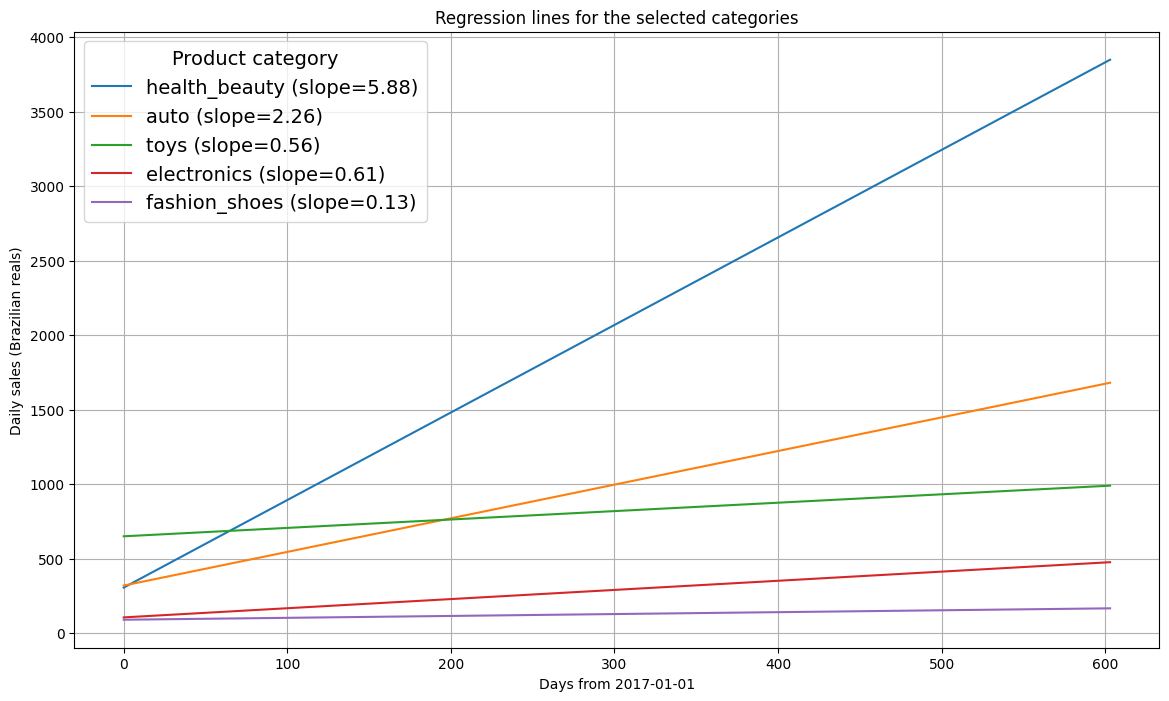

In [31]:
plt.figure(figsize=(14, 8))
days = np.arange(0, 604)
for category in selected_categories:
    lm = df[df['category'] == category]
    slope = lm['slope'].values[0]
    intercept = lm['intercept'].values[0]
    line = intercept + slope * days
    plt.plot(days, line, label=f'{category} (slope={slope:.2f})')
plt.title('Regression lines for the selected categories')
plt.xlabel('Days from 2017-01-01')
plt.ylabel('Daily sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

# SALE FORECASTING PER PRODUCT

In [32]:
forecasted_sales_dec_2018 = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
),
LmPerCategory AS (
    {lm_per_category}
),
ForecastedSales AS (
    SELECT
        DATE(date, '+1 year') AS date,
        category,
        -- Increase in predicted sales * sales 1 year ago
        (intercept + slope * (day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)))
            / (intercept + slope * day) * sales
            AS forecasted_sales
    FROM DailySalesPerCategory
        JOIN LmPerCategory USING (category)
    -- Filter for days of December 2018
    WHERE day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)
        BETWEEN CAST(JULIANDAY('2018-12-01') - JULIANDAY('2017-01-01') AS INTEGER)
        AND CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-01-01') AS INTEGER)
)
SELECT
    CAST(strftime('%d', date) AS INTEGER) AS december_2018_day,
        category,
    -- 5-day moving average
    AVG(forecasted_sales)
        OVER (PARTITION BY category ORDER BY date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING)
        AS moving_avg_sales
FROM ForecastedSales
"""

forecast_2018_12_df = pd.read_sql_query(forecasted_sales_dec_2018, db_connection)
forecast_2018_12_df

,december_2018_day,category,moving_avg_sales
0,1,auto,2438.257278
1,2,auto,2957.096207
2,3,auto,2612.112277
3,4,auto,3034.655653
4,5,auto,2919.956942
...,...,...,...
126,27,toys,1247.841517
127,28,toys,857.343323
128,29,toys,585.209963
129,30,toys,621.773116


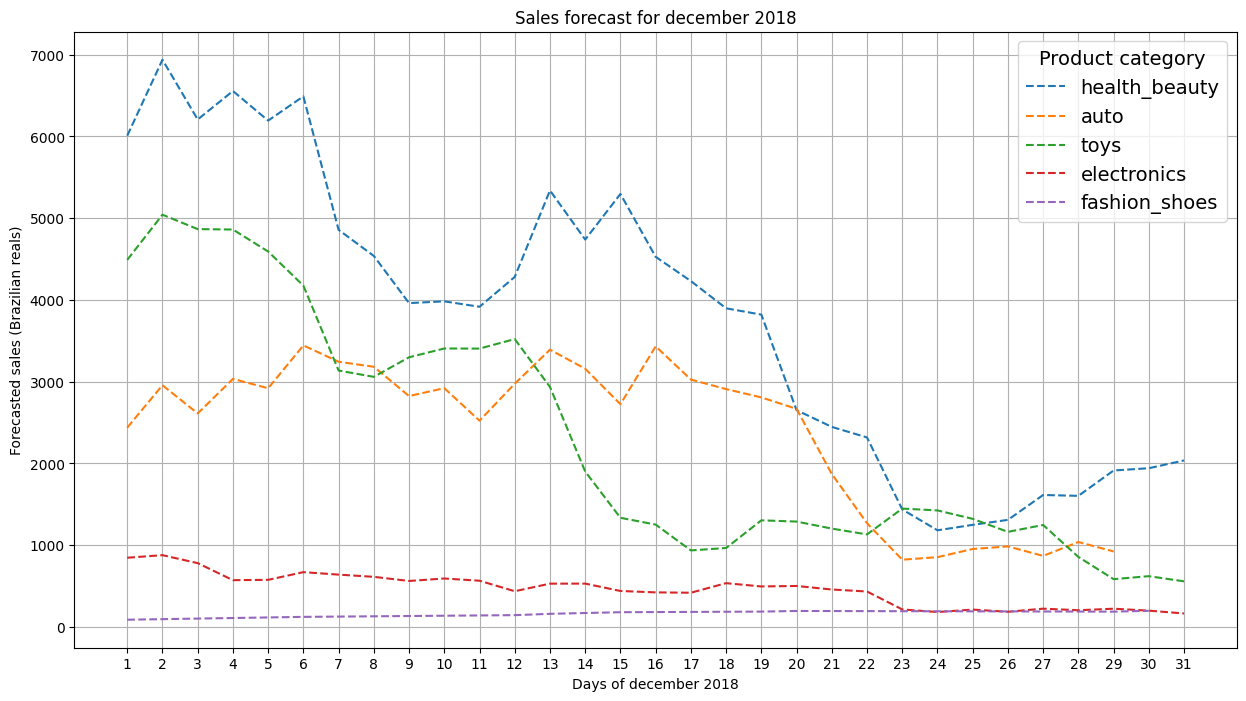

In [33]:
plt.figure(figsize=(15, 8))
for category in selected_categories:
    category_forecast = forecast_2018_12_df[forecast_2018_12_df['category'] == category]
    plt.plot(category_forecast['december_2018_day'], category_forecast['moving_avg_sales'], '--', label=category)
plt.title('Sales forecast for december 2018')
plt.xlabel('Days of december 2018')
plt.ylabel('Forecasted sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()

Our model predicts that health_beauty will be the highest selling category of the five we examined, and its sales will slowly go down until Christmas. toys will have strong sales for the first two weeks but decline sharply after that. auto sales remain stable for the first 3 weeks, but they'll go down afterward. electronics follows a similar trend but fashion_shoes sales seem to be independent of the holiday trends, increasing slightly at the end of the month.

# DELIVERY TIME

In [34]:
order_stage_times_top_10_citites = f"""
SELECT 
    UPPER(customer_city)
        AS city,
    AVG(JULIANDAY(order_approved_at) - JULIANDAY(order_purchase_timestamp))
        AS approved,
    AVG(JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at))
        AS delivered_to_carrier,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date))
        AS delivered_to_customer,
    AVG(JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date))
        AS estimated_delivery
FROM orders
    JOIN customers USING (customer_id)
WHERE  customer_city IN {tuple(top_cities['customer_city'])}
GROUP BY  customer_city
ORDER BY approved + delivered_to_carrier + delivered_to_customer DESC
"""

df = pd.read_sql_query(order_stage_times_top_10_citites, db_connection)
df = df.set_index('city')
df


,approved,delivered_to_carrier,delivered_to_customer,estimated_delivery
city,,,,
SALVADOR,0.498863,2.700868,16.160566,8.755085
PORTO ALEGRE,0.420697,2.809786,12.786769,11.091915
RIO DE JANEIRO,0.383342,2.979133,11.409813,12.504991
BRASILIA,0.432585,2.762064,9.805472,11.333709
BELO HORIZONTE,0.378608,2.848813,7.900486,11.901479
CURITIBA,0.453929,2.690824,7.316206,12.732135
CAMPINAS,0.420262,2.784653,6.611740,8.821432
SAO BERNARDO DO CAMPO,0.349693,2.702651,5.045101,9.799631
SAO PAULO,0.385928,2.726784,4.961921,10.027349


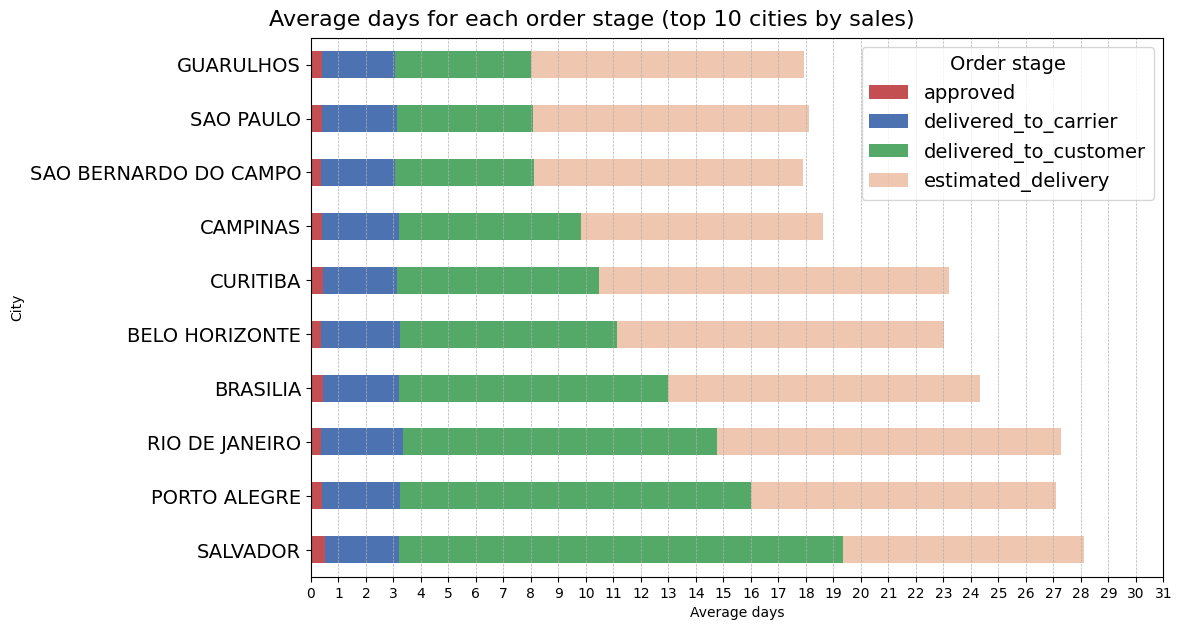

In [35]:
fig, ax = plt.subplots(figsize=(11, 7))
df.plot(kind='barh', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'], ax=ax)
ax.set_xlabel('Average days')
ax.set_ylabel('City')
fig.suptitle('Average days for each order stage (top 10 cities by sales)', fontsize=16, x=0.38, y=0.92)
ax.grid(True, linestyle='--', linewidth=0.5, axis='x')
max_bar_length = int(df.sum(axis=1).max())
ax.set_xticks(range(0, max_bar_length + 4))
ax.tick_params(axis='y', labelsize=14)
plt.legend(title='Order stage', title_fontsize=14, fontsize=14)
plt.show()

As we can see, the time it takes from the order is approved until it is dispatched to the carrier is similar in most cities, about 3 days. By contrast, the time the order takes to get to the customer varies wildly between cities: São Paulo, Guarulhos and São Bernardo do Campo display the same average shipping time of 5 days, while for cities at the bottom of the plot such as Rio de Janeiro, Porto Alegre and Salvador, orders take more than twice as much to get from the carrier to the customer on average. We can also observe that the average estimated delivery dates are at least a week later than the actual delivery, which tells us that these are not accurate predictions but rather pessimistic estimations.

In [36]:
daily_avg_shipping_time = """
SELECT
    DATE(order_purchase_timestamp) AS purchase_date,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp))
        AS avg_delivery_time
FROM orders
WHERE order_purchase_timestamp >= '2017-06-01' AND order_purchase_timestamp <= '2018-06-30'
GROUP BY DATE(order_purchase_timestamp)
"""

df = pd.read_sql_query(daily_avg_shipping_time, db_connection)
df

,purchase_date,avg_delivery_time
0,2017-06-01,11.238623
1,2017-06-02,12.079623
2,2017-06-03,14.255051
3,2017-06-04,12.064359
4,2017-06-05,11.101563
...,...,...
389,2018-06-25,7.280438
390,2018-06-26,8.173340
391,2018-06-27,8.854751
392,2018-06-28,8.601704


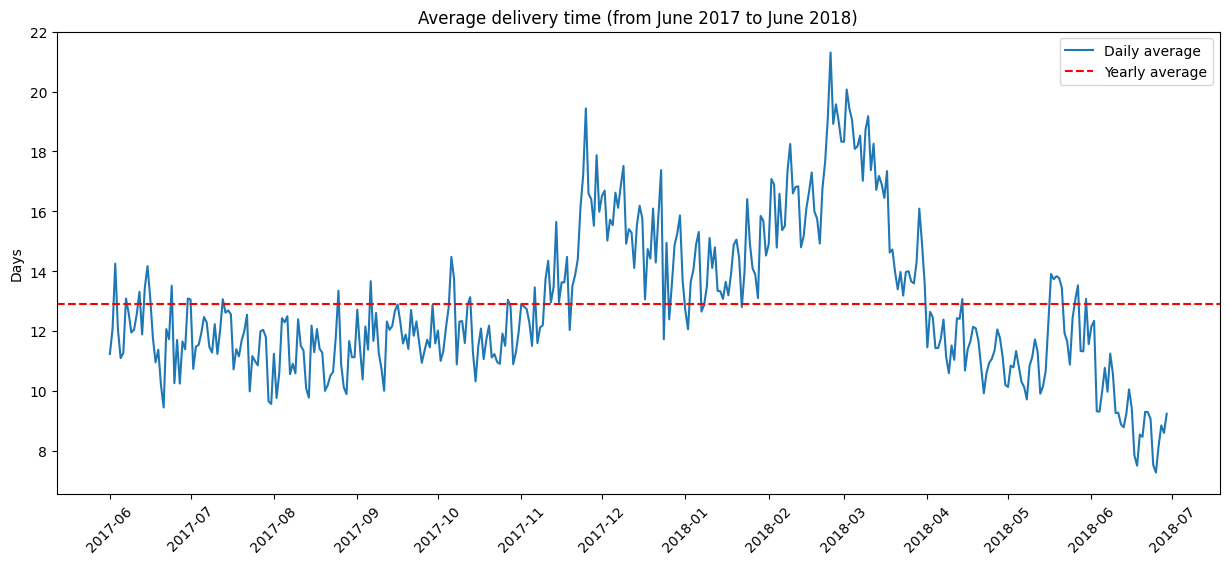

In [37]:
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(df['purchase_date']), df['avg_delivery_time'], label='Daily average')
plt.axhline(y=df['avg_delivery_time'].mean(), color='r', linestyle='--', label='Yearly average')
plt.ylabel('Days')
plt.title('Average delivery time (from June 2017 to June 2018)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.show()

As we can see, there are two periods where shipping times are significantly higher than average: December 2017 and February-March 2018. The delays on december are probably caused by the busy holiday season, but the delays February-March could be due to the postal strikes that happened in certain states of Brazil at the tim

# ORDER REVIEWS

In [38]:
view_table('order_reviews', 5).iloc[:, [1, 2, 4]]


,order_id,review_score,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,None
1,a548910a1c6147796b98fdf73dbeba33,5,None
2,f9e4b658b201a9f2ecdecbb34bed034b,5,None
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...


In [39]:
review_score_count = """
SELECT
    review_score,
    COUNT(*) AS count
FROM order_reviews
GROUP BY review_score
"""
df = pd.read_sql_query(review_score_count, db_connection)
df

,review_score,count
0,1,11424
1,2,3151
2,3,8179
3,4,19142
4,5,57328


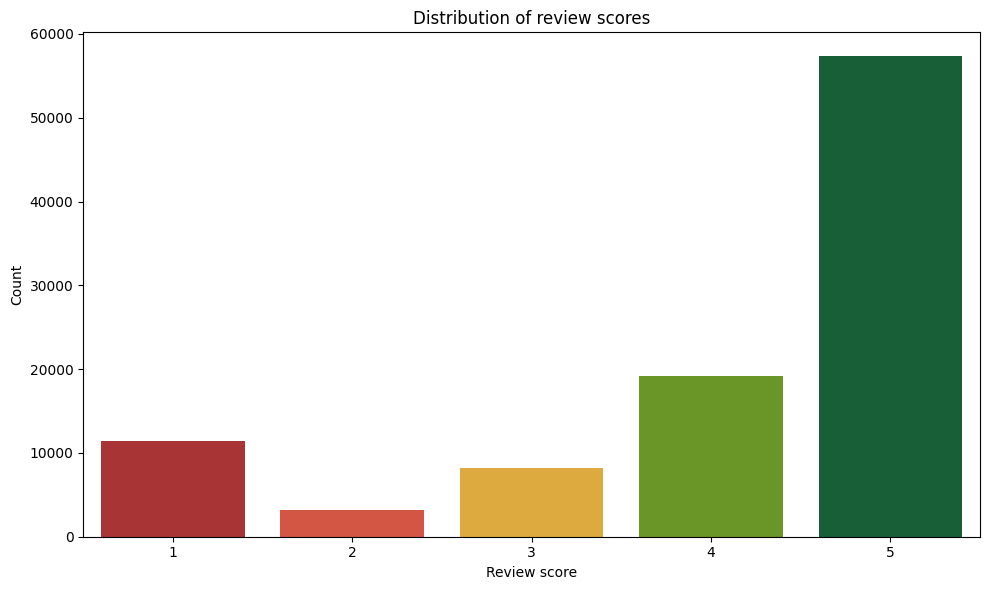

In [40]:
plt.figure(figsize=(10,6))
colors = ['#BC2023', '#EB442C', '#F8B324', '#6da814', '#0C6B37']
sns.barplot(x='review_score', y='count', data=df, hue='review_score', palette=colors, dodge=False)
plt.title('Distribution of review scores')
plt.xlabel('Review score')
plt.ylabel('Count')
plt.legend().remove()
plt.tight_layout()
plt.show()

In [41]:
negative_comments = """
SELECT GROUP_CONCAT(review_comment_message, ' ') AS comments
FROM order_reviews
WHERE review_score IN (1,2)
"""

negative_comments_df = pd.read_sql_query(negative_comments, db_connection)['comments'][0]
negative_comments_df[:150]

'GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU Péssimo Não gostei ! Comprei gato por lebre Sempre compro pela Internet'

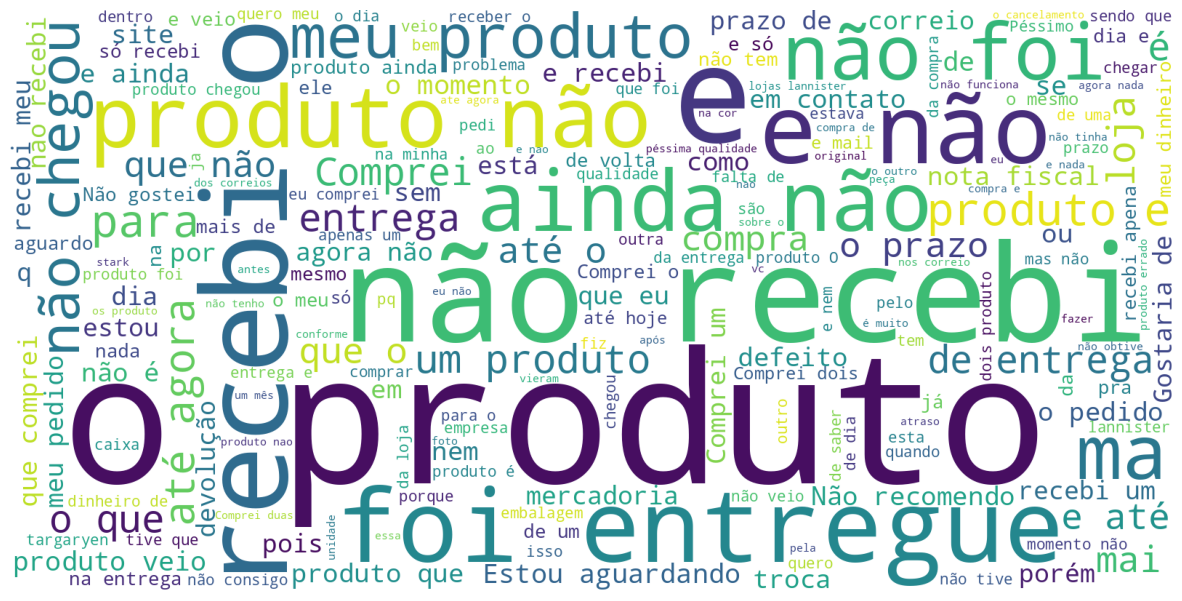

In [42]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(negative_comments_df)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

* If you know some Brazilian, you'll see that the main cause of negative comments is related to shipping delays. Dissatisfaction with the product quality or other order errors seem to be secondary.

# CUSTOMER SEGMENTATION


* segment customer based on these metrics:
* *recency*: how recently did the customer place last order? interaction distance
* *frequency*: how often does the customer place order? interaction freqency
* *monetary value*: how much does the customer spend on average?
* giving customers labels (11) accoring to the score.


In [43]:
rfm_buckets = """
-- 1. Calculate RFM scores
WITH RecencyScore AS (
    SELECT customer_unique_id,
           MAX(order_purchase_timestamp) AS last_purchase,
           NTILE(5) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
FrequencyScore AS (
    SELECT customer_unique_id,
           COUNT(order_id) AS total_orders,
           NTILE(5) OVER (ORDER BY COUNT(order_id) DESC) AS frequency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

MonetaryScore AS (
    SELECT customer_unique_id,
           SUM(price) AS total_spent,
           NTILE(5) OVER (ORDER BY SUM(price) DESC) AS monetary
    FROM orders
        JOIN order_items USING (order_id)
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

-- 2. Assign each customer to a group
RFM AS (
    SELECT last_purchase, total_orders, total_spent,
        CASE
            WHEN recency = 1 AND frequency + monetary IN (1, 2, 3, 4) THEN "Champions"
            WHEN recency IN (4, 5) AND frequency + monetary IN (1, 2) THEN "Can't Lose Them"
            WHEN recency IN (4, 5) AND frequency + monetary IN (3, 4, 5, 6) THEN "Hibernating"
            WHEN recency IN (4, 5) AND frequency + monetary IN (7, 8, 9, 10) THEN "Lost"
            WHEN recency IN (2, 3) AND frequency + monetary IN (1, 2, 3, 4) THEN "Loyal Customers"
            WHEN recency = 3 AND frequency + monetary IN (5, 6) THEN "Needs Attention"
            WHEN recency = 1 AND frequency + monetary IN (7, 8) THEN "Recent Users"
            WHEN recency = 1 AND frequency + monetary IN (5, 6) OR
                recency = 2 AND frequency + monetary IN (5, 6, 7, 8) THEN "Potentital Loyalists"
            WHEN recency = 1 AND frequency + monetary IN (9, 10) THEN "Price Sensitive"
            WHEN recency = 2 AND frequency + monetary IN (9, 10) THEN "Promising"
            WHEN recency = 3 AND frequency + monetary IN (7, 8, 9, 10) THEN "About to Sleep"
        END AS RFM_Bucket
    FROM RecencyScore
        JOIN FrequencyScore USING (customer_unique_id)
        JOIN MonetaryScore USING (customer_unique_id)
)

-- 3. Calculate group statistics for plotting
SELECT RFM_Bucket, 
    -- interaction distance avg
       AVG(JULIANDAY('now') - JULIANDAY(last_purchase)) AS avg_days_since_purchase, 
       AVG(total_spent / total_orders) AS avg_sales_per_customer,
       COUNT(*) AS customer_count
FROM RFM
GROUP BY RFM_Bucket
"""
df = pd.read_sql(rfm_buckets, db_connection)
df


,RFM_Bucket,avg_days_since_purchase,avg_sales_per_customer,customer_count
0,About to Sleep,2710.799706,57.684959,7584
1,Can't Lose Them,2884.103015,350.886817,1723
2,Champions,2537.830271,250.856821,4607
3,Hibernating,2885.112692,182.845816,20288
4,Lost,2887.641470,57.393210,15331
5,Loyal Customers,2668.295735,237.881257,9315
6,Needs Attention,2711.856786,145.904925,6510
7,Potentital Loyalists,2594.990903,130.374773,18114
8,Price Sensitive,2536.454866,34.909351,2220
9,Promising,2627.944539,35.085359,2245


*  I'll plot each group using average recency on the x-axis, average sales per customer on the y-axis and circle size to represent the amount of customers in each group:

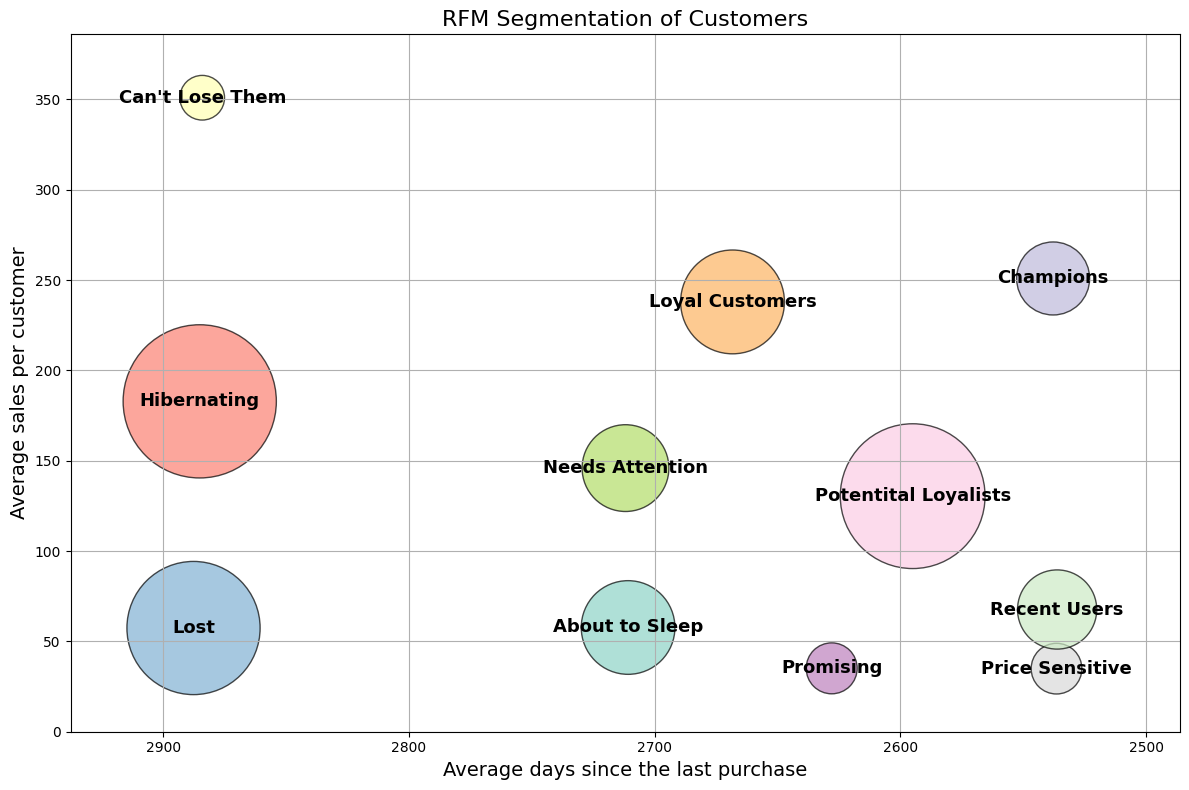

In [44]:
df = df.reset_index(drop=True)

plt.figure(figsize=(12, 8))

# Use a safe bubble size (normalize or clip if needed)
bubble_size = df['customer_count'].clip(lower=5, upper=30000) * 0.6

# Handle color palette safely
colors = sns.color_palette('Set3', n_colors=min(len(df), 12))

# Plot
scatter = plt.scatter(
    df['avg_days_since_purchase'], 
    df['avg_sales_per_customer'],
    s=bubble_size,
    c=colors[:len(df)],
    alpha=0.7,
    edgecolors='k'
)

# Labels
plt.xlabel('Average days since the last purchase', fontsize=14)
plt.ylabel('Average sales per customer', fontsize=14)
plt.title('RFM Segmentation of Customers', fontsize=16)
plt.grid(True)

# Annotations
for i in range(len(df)):
    plt.annotate(
        df['RFM_Bucket'][i], 
        (df['avg_days_since_purchase'][i], df['avg_sales_per_customer'][i]),
        ha='center', va='center', fontsize=13, weight='bold'
    )

# Optional axis inversion for recency logic
plt.gca().invert_xaxis()

# Set smart limits
plt.xlim(df['avg_days_since_purchase'].max() + 50, df['avg_days_since_purchase'].min() - 50)
plt.ylim(0, df['avg_sales_per_customer'].max() * 1.1)

plt.tight_layout()
plt.show()

The previous plot shows us where each customer segment falls in terms of recency and sales. For example, the 'Champions' segment on the top right has high sales and has purchased recently, while the 'Lost' segment on the opposite side has low sales and no recent purchases.

In [45]:
repeat_customer_proportion = """
WITH CustomerOrders AS (
    SELECT COUNT(orders.order_id) AS order_count
    FROM orders JOIN customers USING (customer_id)
    GROUP BY customers.customer_unique_id
)
SELECT
    CASE WHEN order_count > 1 THEN 'repeat' ELSE 'one-time' END AS order_type,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM CustomerOrders), 1) AS proportion
FROM CustomerOrders
GROUP BY order_type
"""

df = pd.read_sql_query(repeat_customer_proportion, db_connection)
df

,order_type,proportion
0,one-time,96.9
1,repeat,3.1


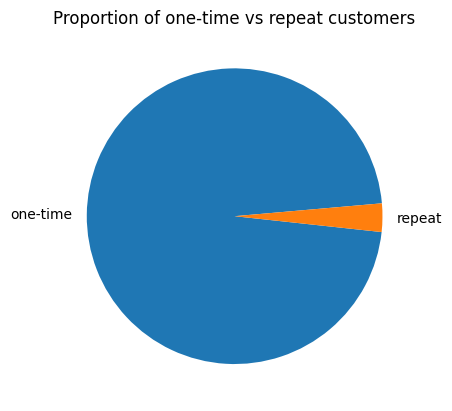

In [46]:
fig, ax = plt.subplots()
ax.pie(df['proportion'], labels=df['order_type'], startangle=5)
ax.set_title('Proportion of one-time vs repeat customers')
fig.set_facecolor('white')
plt.show()

so we have mostly one-time



# CUSTOMER LIFTIME VALUE

In [47]:
view_table('order_payments', 5)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [48]:
clv = """
WITH CustomerData AS (
    SELECT
        customer_unique_id,
        customer_zip_code_prefix AS zip_code_prefix,
        COUNT(DISTINCT orders.order_id) AS order_count,
        SUM(payment_value) AS total_payment,
        JULIANDAY(MIN(order_purchase_timestamp)) AS first_order_day,
        JULIANDAY(MAX(order_purchase_timestamp)) AS last_order_day
    FROM customers
        JOIN orders USING (customer_id)
        JOIN order_payments USING (order_id)
    GROUP BY customer_unique_id
)
SELECT
    customer_unique_id,
    zip_code_prefix,
    order_count AS PF,
    total_payment / order_count AS AOV,
    CASE
        WHEN (last_order_day - first_order_day) < 7 THEN
            1
        ELSE
            (last_order_day - first_order_day) / 7
        END AS ACL
FROM CustomerData
"""

pd.read_sql(clv, db_connection)


,customer_unique_id,zip_code_prefix,PF,AOV,ACL
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,1,141.90,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,1,27.19,1.0
2,0000f46a3911fa3c0805444483337064,88115,1,86.22,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,66812,1,43.62,1.0
4,0004aac84e0df4da2b147fca70cf8255,18040,1,196.89,1.0
...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,55250,1,2067.42,1.0
96091,fffea47cd6d3cc0a88bd621562a9d061,44054,1,84.58,1.0
96092,ffff371b4d645b6ecea244b27531430a,78552,1,112.46,1.0
96093,ffff5962728ec6157033ef9805bacc48,29460,1,133.69,1.0


my goal is to build a map of the distribution of CLV around Brazil, we'll also need to add the latitude and longitude of each zip code prefix, which can be found in the table geolocation:

In [49]:
view_table('geolocation', 5)


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


To calculate CLV we just multiply each of its terms:

***> CLV = PF⋅AOV⋅ACL***

In [50]:
avg_clv_per_zip_prefix = f"""
WITH CLV AS (
    {clv}
)
SELECT
    zip_code_prefix AS zip_prefix,
    AVG(PF * AOV * ACL) AS avg_CLV,
    COUNT(customer_unique_id) AS customer_count,
    geolocation_lat AS latitude,
    geolocation_lng AS longitude
FROM CLV
    JOIN geolocation ON CLV.zip_code_prefix = geolocation.geolocation_zip_code_prefix
GROUP BY zip_code_prefix
"""

df = pd.read_sql(avg_clv_per_zip_prefix, db_connection)
df

,zip_prefix,avg_CLV,customer_count,latitude,longitude
0,1003,98.970000,17,-23.549032,-46.635313
1,1004,99.055000,44,-23.550116,-46.635122
2,1005,1082.762826,125,-23.549819,-46.635606
3,1006,434.025000,18,-23.550524,-46.636694
4,1007,126.387500,104,-23.550393,-46.637302
...,...,...,...,...,...
14821,99960,97.315000,10,-27.953797,-52.029641
14822,99965,113.795000,12,-28.173892,-52.038447
14823,99970,252.740000,21,-28.345143,-51.876926
14824,99980,111.385000,52,-28.389218,-51.846012


With these data we can create an interactive map using the folium library. For each zip code prefix a circle is drawn in the map, using opacity to indicate CLV and size to indicate the number of customers:

In [51]:
# import folium

# map = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)
# for i, zip_prefix in df.iterrows():
#     folium.CircleMarker(
#         location=[zip_prefix['latitude'], zip_prefix['longitude']],
#         radius=0.1*np.sqrt(zip_prefix['customer_count']),
#         color=None,
#         fill_color='#85001d',
#         fill_opacity=0.1+0.1*np.sqrt(zip_prefix['avg_CLV']/df['avg_CLV'].max()),
#         popup=(
#             f"<b>Zip Code Prefix:</b> {int(zip_prefix['zip_prefix'])}<br>"
#             f"<b>Average CLV:</b> {int(zip_prefix['avg_CLV'])}<br>"
#             f"<b>Customers:</b> {int(zip_prefix['customer_count'])}"
#         )
#     ).add_to(map)
# map

As we can see in the map, most of the customer value for Olist's sellers is concentrated in the south-east of Brazil, in the most populated areas: the state of São Paulo, and around the cities of Rio de Janeiro and Belo Horizonte

# PRODUCT AFFINITY

In [52]:
min_orders = 5

most_ordered_products = f"""
SELECT
    products.product_id,
    product_category_name_english AS category,
    COUNT(order_id) AS orders_count
FROM order_items
    JOIN products USING (product_id)
    JOIN product_category_name_translation AS tr
        ON products.product_category_name = tr.product_category_name
GROUP BY products.product_id
    HAVING COUNT(order_id) > {min_orders}
"""

most_ordered_products_df = pd.read_sql(most_ordered_products, db_connection)
most_ordered_products_df

,product_id,category,orders_count
0,001795ec6f1b187d37335e1c4704762e,consoles_games,9
1,001b72dfd63e9833e8c02742adf472e3,furniture_decor,14
2,00210e41887c2a8ef9f791ebc780cc36,health_beauty,7
3,002159fe700ed3521f46cfcf6e941c76,fashion_shoes,8
4,00250175f79f584c14ab5cecd80553cd,housewares,11
...,...,...,...
3798,ffb97eb64c6fe1baada2410288c04457,perfumery,8
3799,ffc0b406806006602c5853b00ab5f7fd,christmas_supplies,6
3800,ffc9caf33e2d1e9f44e3e06da19085f7,health_beauty,27
3801,ffd4bf4306745865e5692f69bd237893,fashion_bags_accessories,8


In [53]:
most_ordered_product_ids = tuple(most_ordered_products_df['product_id'])

products_often_ordered_together = f"""
SELECT
    oi1.product_id AS product_id1,
    oi2.product_id AS product_id2,
    COUNT(DISTINCT oi1.order_id) AS common_orders_count
FROM order_items AS oi1
    JOIN order_items AS oi2
        ON oi1.order_id = oi2.order_id -- Same order
        AND oi1.product_id < oi2.product_id -- Avoid permutations
WHERE
    oi1.product_id IN {most_ordered_product_ids} AND
    oi2.product_id IN {most_ordered_product_ids}
GROUP BY
    oi1.product_id,
    oi2.product_id
    HAVING COUNT(DISTINCT oi1.order_id) > {min_orders}
"""

products_often_ordered_together_df = pd.read_sql(products_often_ordered_together, db_connection)
products_often_ordered_together_df

,product_id1,product_id2,common_orders_count
0,060cb19345d90064d1015407193c233d,98d61056e0568ba048e5d78038790e77,6
1,0bcc3eeca39e1064258aa1e932269894,422879e10f46682990de24d770e7f83d,6
2,0d85c435fd60b277ffb9e9b0f88f927a,ee57070aa3b24a06fdd0e02efd2d757d,6
3,18486698933fbb64af6c0a255f7dd64c,dbb67791e405873b259e4656bf971246,7
4,35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,29
5,368c6c730842d78016ad823897a372db,53759a2ecddad2bb87a079a1f1519f73,8
6,36f60d45225e60c7da4558b070ce4b60,3f14d740544f37ece8a9e7bc8349797e,12
7,36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,34
8,389d119b48cf3043d311335e499d9c6b,422879e10f46682990de24d770e7f83d,11
9,389d119b48cf3043d311335e499d9c6b,53759a2ecddad2bb87a079a1f1519f73,9


# co-purchase graph analysis

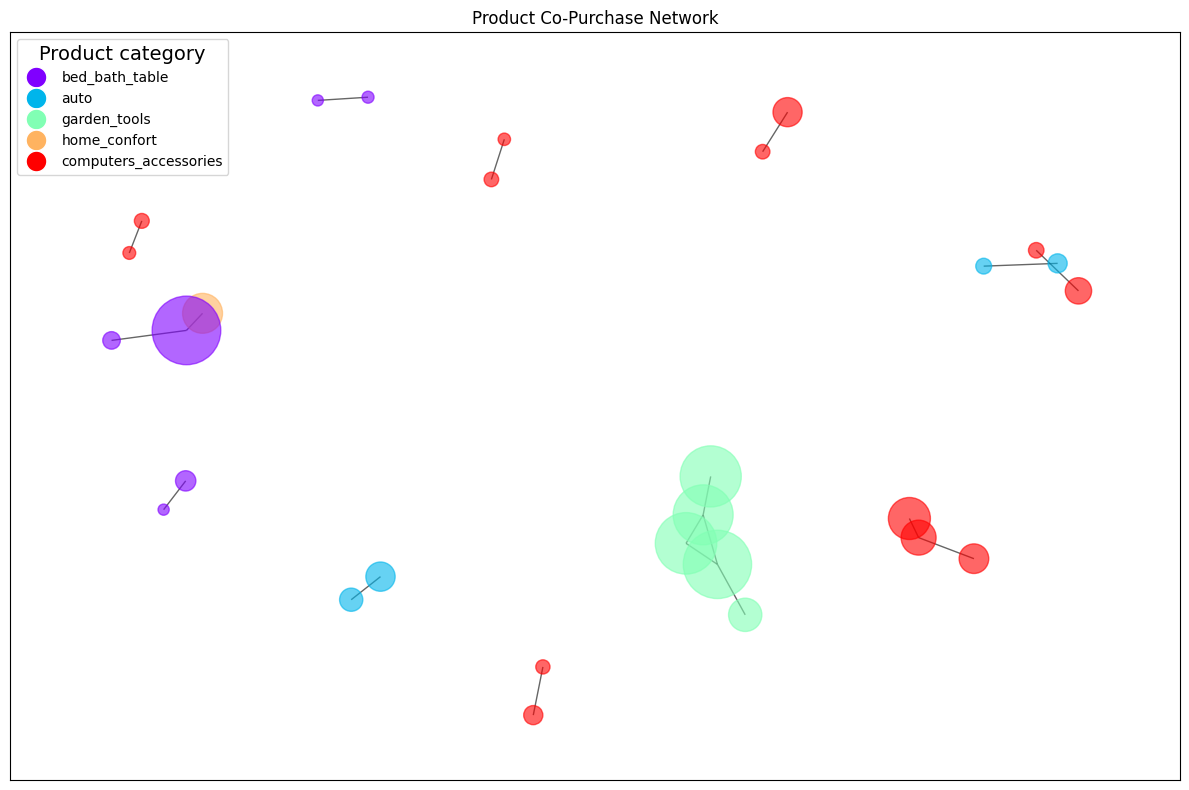

In [54]:
import networkx as nx

G = nx.Graph()
# Add nodes to the graph
for _, product in most_ordered_products_df.iterrows():
    G.add_node(product['product_id'], category=product['category'], orders_count=product['orders_count'])
# Add edges to the graph
for _, pair in products_often_ordered_together_df.iterrows():
    G.add_edge(pair['product_id1'], pair['product_id2'], weight=pair['common_orders_count'])
# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))
# Assign colors to categories
categories = list(set(nx.get_node_attributes(G, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))
# Draw the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G, k=0.5, iterations=50)
node_sizes = [G.nodes[n]['orders_count'] * 5 for n in G.nodes]
node_colors = [category_colors[G.nodes[n]['category']] for n in G.nodes]
nx.draw_networkx(G, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                   for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14)
plt.title("Product Co-Purchase Network")
plt.tight_layout()
plt.show()

* In the graph each circle represents a product and its color indicates the product category it belongs to. A line between two products indicates that they are often bought together as part of the same order. The circle's size indicates product importance, how many orders in the whole dataset contain this product.


* There are 5 products in the Garden tools category that are often bought together. There's also a product from the Bed, Bath, Table category that is often bought together with another from the Home confort category. We can also observe that some products in the Auto and Computer accessories categories are also often bought with other items of the same category